In [1]:
# import display libs
from IPython.display import Image
%matplotlib inline
from IPython.display import Latex

In [2]:
# import libs
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt


# setup figure params
figureparams = {'axes.labelsize': 24,
           'axes.titlesize': 20,
           'axes.linewidth': 1.3,
           'font.size': 20,
           'legend.fontsize': 18,
           'figure.figsize': (10,7),
           'font.family': 'serif',
           'font.serif': 'Computer Modern Roman',
           'xtick.labelsize': 18,
           'xtick.major.size': 5.5,
           'xtick.major.width': 1.3,
           'ytick.labelsize': 18,
           'ytick.major.size': 5.5,
           'ytick.major.width': 1.3,
           'text.usetex': True,
           'figure.autolayout': True}
plt.rcParams.update(figureparams)
matplotlib.rcParams['text.usetex']=False
matplotlib.rcParams['text.latex.unicode']=True
matplotlib.get_configdir()

C:\Users\EdwardJansenADC\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.


'C:\\Users\\EdwardJansenADC\\.matplotlib'

# Population Stability
### Contents
    1. Herfindahl-Hirschman Index (HHI)
    2. Population Stability Index (PSI)
    3. Other tests
        a. Kolmogorov-Smirnov test
        b. Stability of the migration matrix

## 1. Herfindahl-Hirschman Index (HHI)

Originally, the HHI is a measure of the size of firms in relation to the industry and an indicator of the amount of competition among them. Equivalently, it is a measure of the (in)equality of wealth within a population. In the context of credit risk, the HHI measures the the value of loans (I think) per risk bucket as share of the total portfolio. It is computed as
\begin{equation}
\text{HHI} = \sum_i^N s_i^2,
\end{equation}
where $N$ is the number of buckets. Thus, it is a measure of how uniformly loans are distributed over the buckets (correct?).

Note:
Apparently, one can prove that 
\begin{equation}
\text{Gini} \leq \frac{ N^2 - \text{HHI} }{N^2 - N} \xrightarrow{N \rightarrow \infty} 1 - \text{HHI},
\end{equation}
which implies that a low Gini may not be due to low discriminatory power, but to inadequate bucketing.
*(I like this result, but could not find a proof and am too busy to try myself. Also, I think the large $N$ limit is a bit shaky.)*

In [4]:
# HHI function
def HHI(n_ppl):
    tot_ppl = np.sum(n_ppl)
    share = n_ppl / tot_ppl
    # compute HHI
    HHI = np.sum(share**2)
    return HHI

In [5]:
# number of ppl per bucket
n_ppl = np.round(np.random.rand(20)*10, 0)
print("HHI equals: " + str(HHI(n_ppl)))

HHI equals: 0.06393169512703038


Let's look at some extreme cases:
    - complete equality, small $n_\text{tot}$;
    - complete equality, large $n_\text{tot}$;
    - large inequality;
    - complete inequality:

In [16]:
# complete equality
n_ppl = np.ones(2)
print("two ppl own exactly the same")
print("HHI equals: " + str(HHI(n_ppl)))

two ppl own exactly the same
HHI equals: 0.5


In [15]:
# HHI also sensitive for n_tot
n_ppl = np.ones(10000000) 
print("A lot of ppl own exactly the same")
print("HHI equals: " + str(HHI(n_ppl)))

A lot of ppl own exactly the same
HHI equals: 1.000000000000013e-07


In [13]:
# large inequality
n_ppl = np.zeros(20)
n_ppl[3] = 10
n_ppl[18] = 90
print("two ppl own everything, the rest nothing")
print("HHI equals: " + str(HHI(n_ppl)))

two ppl own everything, the rest nothing
HHI equals: 0.8200000000000001


In [14]:
# complete inequality
n_ppl = np.zeros(20)
n_ppl[18] = 10000
print("one of 20 ppl owns everything, the rest nothing")
print("HHI equals: " + str(HHI(n_ppl)))

one of 20 ppl owns everything, the rest nothing
HHI equals: 1.0


## 2. Population Stability Index (PSI)

The PSI is a measure of the change in share of clients in a certain class at a specific snapshot compared to a set baseline. Let $B$ denote the baseline set, $S$ the snapshot set and $p_{K, i}$ the percentage of clients from set $K$ in class $i$. The, the PSI is given as
\begin{equation}
\text{PSI}_{B,S} = \sum_i \left( p_{B, i } - p_{S, i} \right) \ln \left[ \frac{p_{B,i}}{p_{S,i}}\right].
\end{equation}
(Note that this is mathematically equal to the infamous *Information Value* from credit risk scoring.)

Because of the $\ln$, the PSI is not stable against empty classes. A solution would be to let the sum run over all non-empty classes, but this only works when $p_{B,i} = p_{S,i} = 0$. As such, it is recommended that the classes are grouped in such a way that either $p_{B,i} = p_{S,i} = 0$ or $p_{B,i} \neq 0 \neq p_{S,i}$.

Quora lists the following rule of thumb:
PSI
- $\leq 0.1$: little change [no action required]
- $0.1 - 0.25$: little change but to small to determine [still no action required]    (I doubt this seeing the example below)
- $> 0.25$: significant shift [action required - merits further investigation]


In [17]:
# PSI
# code currently not robust against 0 ppl in bucket
# proper implementation shld do smth like assigning at least 5% of obs to a bucket
# idea stays the same though
def PSI(n_ppl_old, n_ppl_new):              
    tot_ppl_new = np.sum(n_ppl_new)
    tot_ppl_old = np.sum(n_ppl_old)
    share_new = n_ppl_new / tot_ppl_new
    share_old = n_ppl_old / tot_ppl_old
    # compute PSI
    PSI = np.sum( (share_old - share_new) * (np.log(share_old) - np.log(share_new)) )    
    return PSI

In [31]:
# number of ppl per bucket + small change
n_ppl_old = np.round(np.random.rand(20)*10, 0) + 1 # + 1 so that we never have 0 ppl to insure stability
n_ppl_new = n_ppl_old +  np.round(np.random.rand(20), 0) - np.round(np.random.rand(20), 0)
print(PSI(n_ppl_old, n_ppl_new))

0.016556566487222507


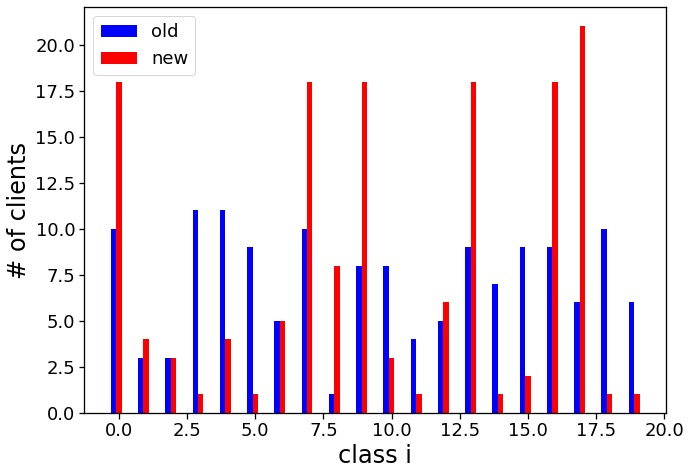

In [45]:
# plot population
x = np.linspace(0, len(n_ppl_old)-1, len(n_ppl_old)).astype(int)
plt.bar(x-0.2, n_ppl_old, width=0.2, color='b', align='center', label='old')
plt.bar(x, n_ppl_new, width=0.2, color='r', align='center', label='new')
plt.xlabel('class i')
plt.ylabel('# of clients')
plt.legend()

In [46]:
# big change
n_ppl_old = np.round(np.random.rand(20)*10, 0) + 1
n_ppl_new = n_ppl_old +  np.round(np.random.rand(20)*20, 0) - np.round(np.random.rand(20)*20, 0)
n_ppl_new[n_ppl_new <= 0] = 1 # because we cannot have negative number of clients in a class
print(PSI(n_ppl_old, n_ppl_new))

0.7867168339109127


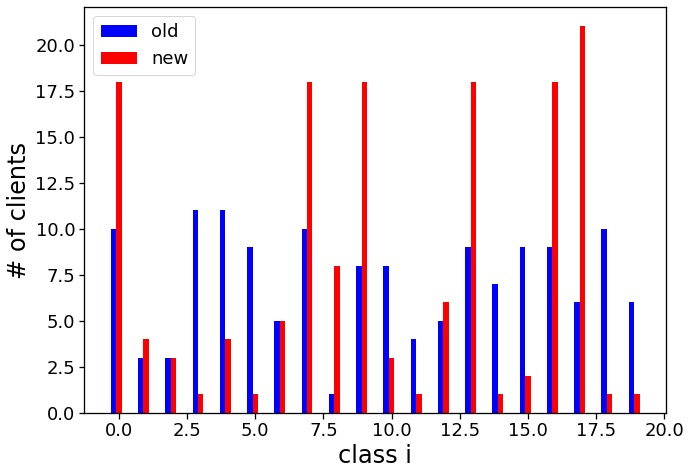

In [43]:
# plot population
x = np.linspace(0, len(n_ppl_old)-1, len(n_ppl_old))
plt.bar(x-0.2, n_ppl_old, width=0.2, color='b', align='center', label='old')
plt.bar(x, n_ppl_new, width=0.2, color='r', align='center', label='new')
plt.xlabel('class i')
plt.ylabel('# of clients')
plt.legend()

## Other tests

#### Kolmogorov-Smirnov test

The two-sample KS test is a nonparametric test that can be used to test whether two samples originate from the same underlying distribution. As such, it can be use dto assess the discriminatory power of a model with a binary outcome variable, but also as a measure of population stability. The test is implemented elsewhere.

#### Stability of the migration matrix

The migration matrix contains the probabilities for a client in a certain risk bucket $i$ to transition to risk bucket $j$. In general, we would expect that most clients stay in their original risk bucket, a few will transition to the adjacent risk buckets (either higher or lower risk), even fewer will transition $2$ buckets within one snapshot, and so on. As such, we expect the matrix probablities to be monotonically decreasing in the row direction. To test whether $p_{i,j} > p_{i, j+1}$ statistically speaking, one can perform a pairwise z-test. This framework is set up in another .ipynb.